# Problem Statement

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .
We  suggest  spending  1­2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

# Import Relevant Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Read In Data

In [3]:
users = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
logins = pd.read_csv('takehome_user_engagement.csv', encoding = 'ISO-8859-1')
logins.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Clean and Explore Data

In [6]:
# clean logins dataframe
logins['time_stamp'] = pd.to_datetime(logins['time_stamp'])
logins.set_index('time_stamp', inplace = True)

In [7]:
# create target variable by resampling logins dataframe for each userid
user_ids = users.object_id
target = []

for user in user_ids:
    
    x = logins[logins['user_id'] == user].resample('7D').count()['user_id'].max()
    if x >= 3:
        target.append(1)
    else:
        target.append(0)
        
users['target'] = target

In [10]:
# change creation time to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])

# change creation source to category
users['creation_source'] = users['creation_source'].astype('category')

# change last session creation time to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])

# fill missing values and create an indicator variable that may be useful for modeling
users['invited_by_user_id'].fillna(0, inplace = True)
users['referred'] = [0 if x == 0 else 1 for x in users['invited_by_user_id']]

# fill missing values for last_session_creation_time
users['last_session_creation_time'].fillna(0, inplace = True)

In [33]:
# Define plotting helper functions
def plot_cat_vs_binary_target(df, target, variables):
    """Plot barplots of a set of categorical variables against a binary target"""
    
    # Determine subplot layout for given number of plots
    subplotsdict = {
        1: (1,1),
        2: (1,2),
        3: (2,2),
        4: (2,2),
        5: (3,2),
        6: (3,2),
        7: (3,3),
        8: (3,3),
        9: (3,3),
        10:(4,3),
        11:(4,3),
        12:(4,3)
    }
    
    # Set basic layout of plots
    sns.set_context('poster')
    sns.set_style('whitegrid')
    
    # create subplots
    r, c = subplotsdict[len(variables)]
    fig, axes = plt.subplots(r, c, figsize = (20,20))
    
    for i in range(len(variables)):
        
        data = pd.pivot_table(df, index = variables[i], values = target, aggfunc = 'mean')
        
        if len(variables) == 1:
            ax = axes
        else:
            ax = axes.ravel()[i]
        
        sns.barplot(x = data.index, y = data[target], ax = ax)
        ax.set_xlabel(variables[i])
        ax.set_ylabel(target)
        ax.set_title(target + ' by ' + variables[i])
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    
    plt.tight_layout()
    plt.show()
    
def plot_num_vs_binary_target(df, target, variables):
    """Plot barplots of a set of categorical variables against a binary target"""
    
    # Determine subplot layout for given number of plots
    subplotsdict = {
        1: (1,1),
        2: (1,2),
        3: (2,2),
        4: (2,2),
        5: (3,2),
        6: (3,2),
        7: (3,3),
        8: (3,3),
        9: (3,3),
        10:(4,3),
        11:(4,3),
        12:(4,3)
    }
    
    # Set basic layout of plots
    sns.set_context('poster')
    sns.set_style('whitegrid')
    
    # create subplots
    r, c = subplotsdict[len(variables)]
    fig, axes = plt.subplots(r, c, figsize = (20,20))
    
    for i in range(len(variables)):
        
        data = pd.pivot_table(df, index = target, values = variables[i], aggfunc = 'mean')
        
        if len(variables) == 1:
            ax = axes
        else:
            ax = axes.ravel()[i]
        
        sns.barplot(x = data.index, y = data[variables[i]], ax = ax)
        ax.set_ylabel(variables[i])
        ax.set_xlabel(target)
        ax.set_title(variables[i] + ' by ' + target)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
        
    plt.tight_layout()
    plt.show()

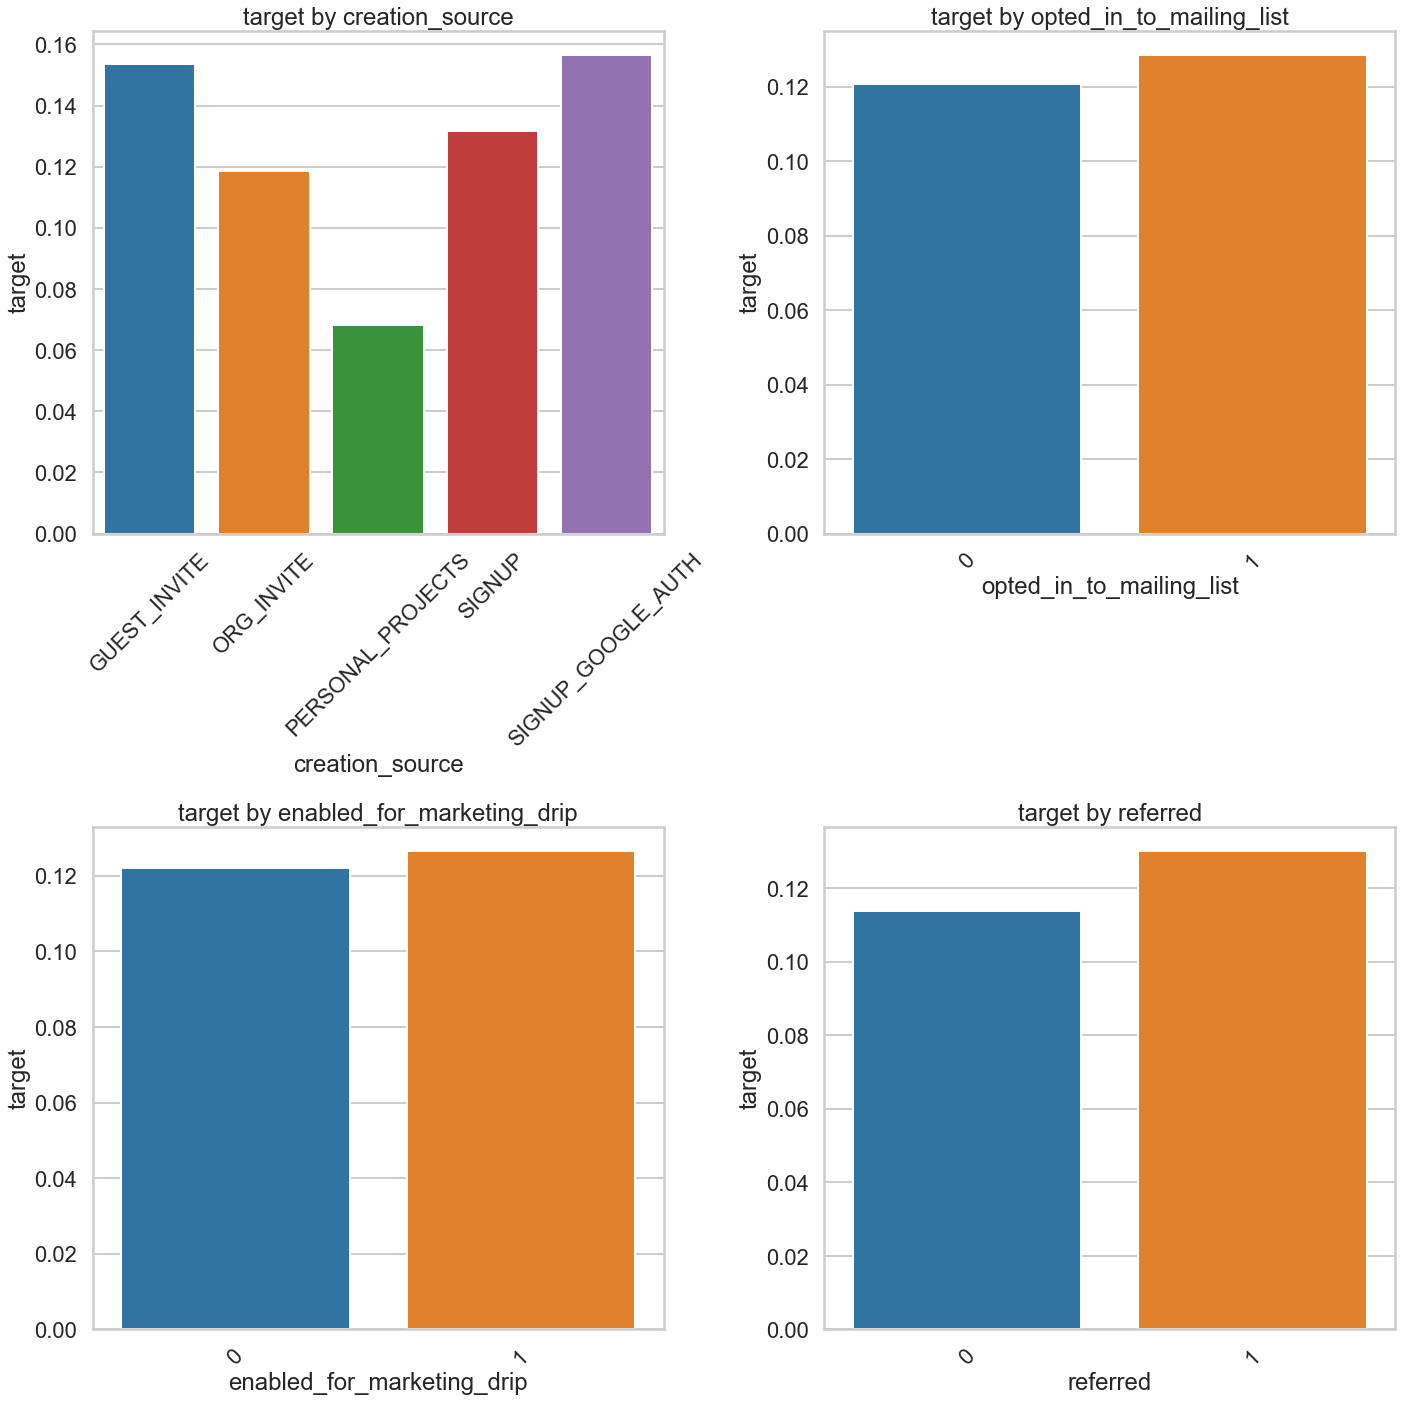

In [34]:
# plot categorical variables
plot_cat_vs_binary_target(users, 'target', ['creation_source', 'opted_in_to_mailing_list','enabled_for_marketing_drip', 'referred'])

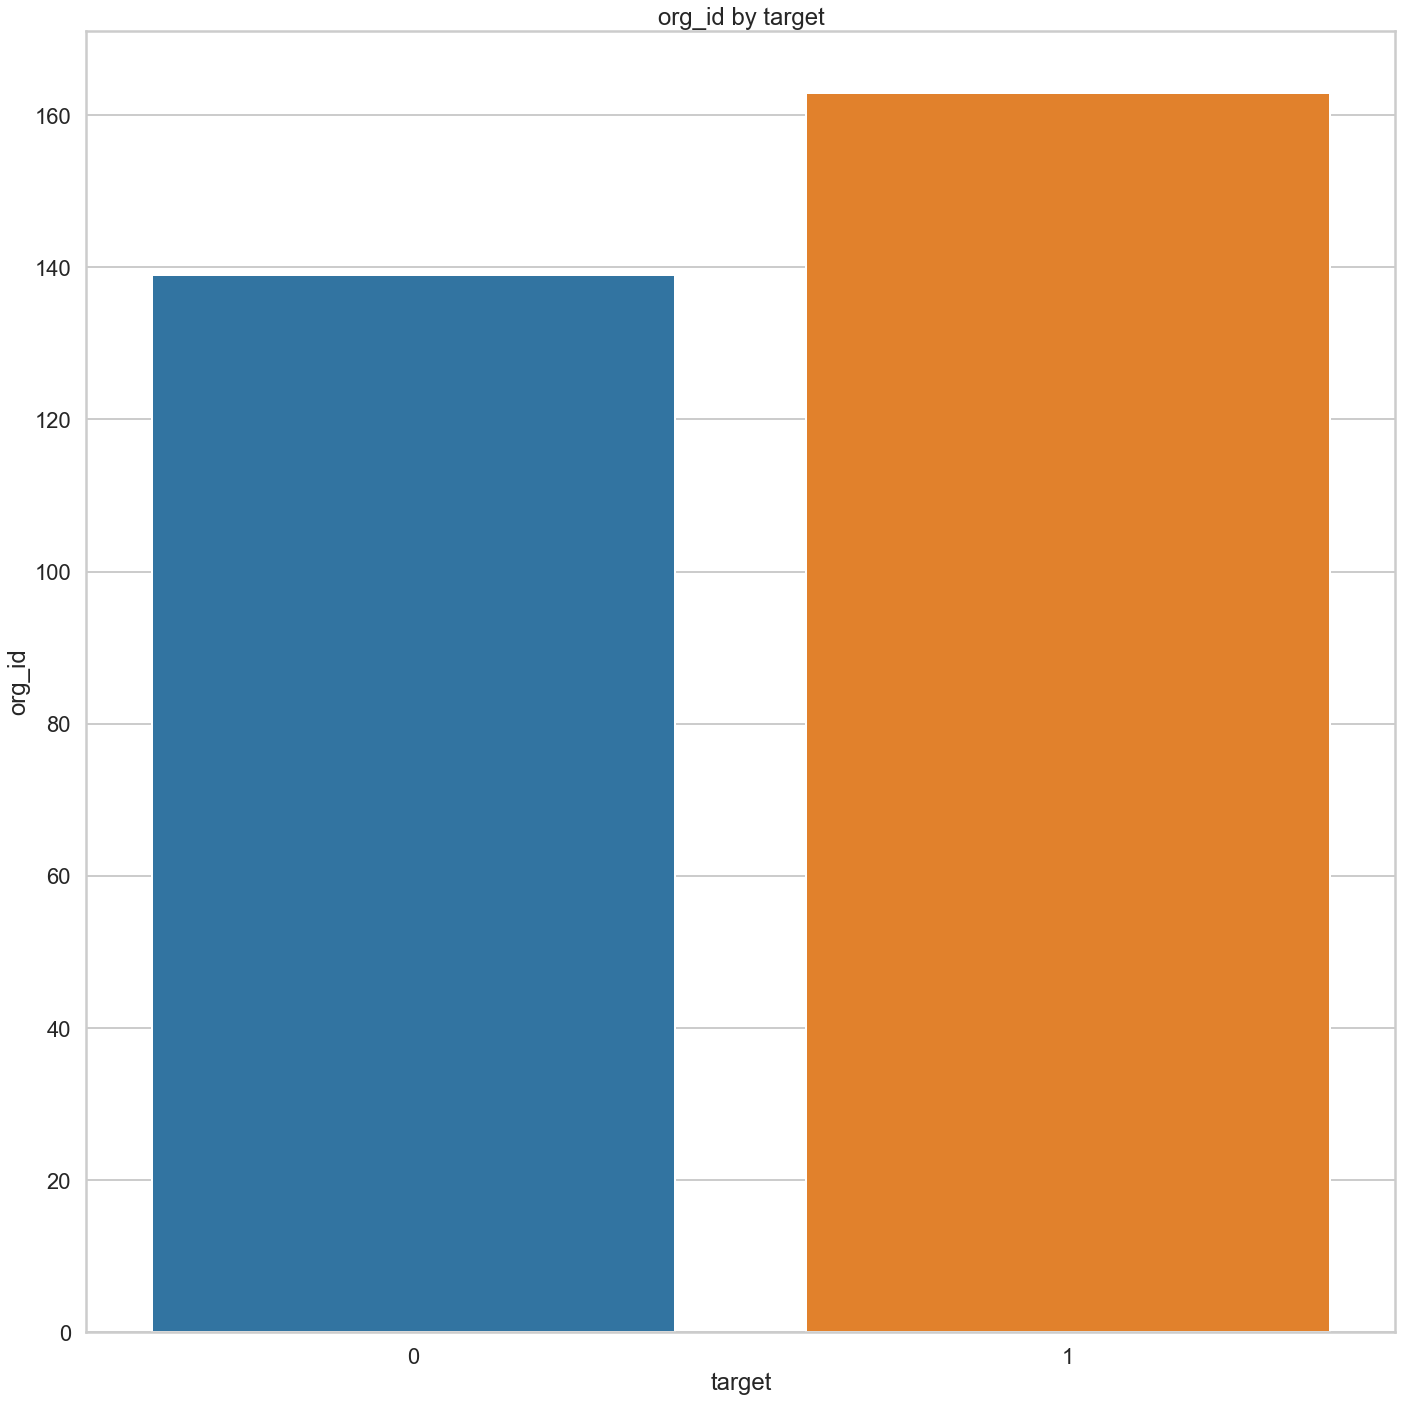

In [14]:
# plot org_id, even though it is actually a very large categorical variable
plot_num_vs_binary_target(users, 'target', ['org_id'])

# Preprocessing

In [27]:
users2 = pd.get_dummies(users, columns = ['creation_source'], drop_first = True)

X = users2.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'invited_by_user_id', 'target', 'org_id'], axis = 1)
y = np.ravel(users2.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Model 1 - XGBoost

In [21]:
xg = XGBClassifier()
params = {'n_estimators': [100],
         'max_depth': randint(2, 10),
         'learning_rate': uniform(0,0.3),
         'verbosity': [1],
         'n_jobs': [-1]
        }

cvxg = RandomizedSearchCV(xg, param_distributions = params, n_iter = 20, n_jobs = -1, scoring = 'f1', random_state = 123)
cvxg.fit(X_train, y_train)

pd.DataFrame(cvxg.cv_results_).sort_values('rank_test_score')

[20:36:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\atyou\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_n_jobs,param_verbosity,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.413893,0.013718,0.005186,3.989936e-04,0.208941,8,100,-1,1,"{'learning_rate': 0.2089407556793585, 'max_dep...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
17,0.487098,0.013800,0.004787,3.988505e-04,0.196416,8,100,-1,1,"{'learning_rate': 0.19641639224094595, 'max_de...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
16,0.436433,0.005904,0.005186,3.991130e-04,0.216733,3,100,-1,1,"{'learning_rate': 0.21673301477106646, 'max_de...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
15,0.429053,0.003302,0.005386,4.886166e-04,0.222089,6,100,-1,1,"{'learning_rate': 0.22208891722043642, 'max_de...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14,0.392550,0.036501,0.004987,2.431402e-07,0.25483,3,100,-1,1,"{'learning_rate': 0.25482953822333687, 'max_de...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13,0.654251,0.029213,0.005785,3.988743e-04,0.128359,7,100,-1,1,"{'learning_rate': 0.12835904725134584, 'max_de...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12,0.531180,0.027047,0.005186,3.990651e-04,0.159465,6,100,-1,1,"{'learning_rate': 0.1594654121525515, 'max_dep...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11,0.602389,0.015970,0.004987,3.568323e-07,0.132077,6,100,-1,1,"{'learning_rate': 0.13207715341922288, 'max_de...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,0.456380,0.009579,0.005186,3.986598e-04,0.221399,9,100,-1,1,"{'learning_rate': 0.2213986217196107, 'max_dep...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.306979,0.003116,0.004987,1.907349e-07,0.208427,2,100,-1,1,"{'learning_rate': 0.2084265531555807, 'max_dep...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [22]:
xg = cvxg.best_estimator_
y_pred = xg.predict(X_test)
classification_report(y_test, y_pred, output_dict = True)['1']

C:\Users\atyou\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 327}

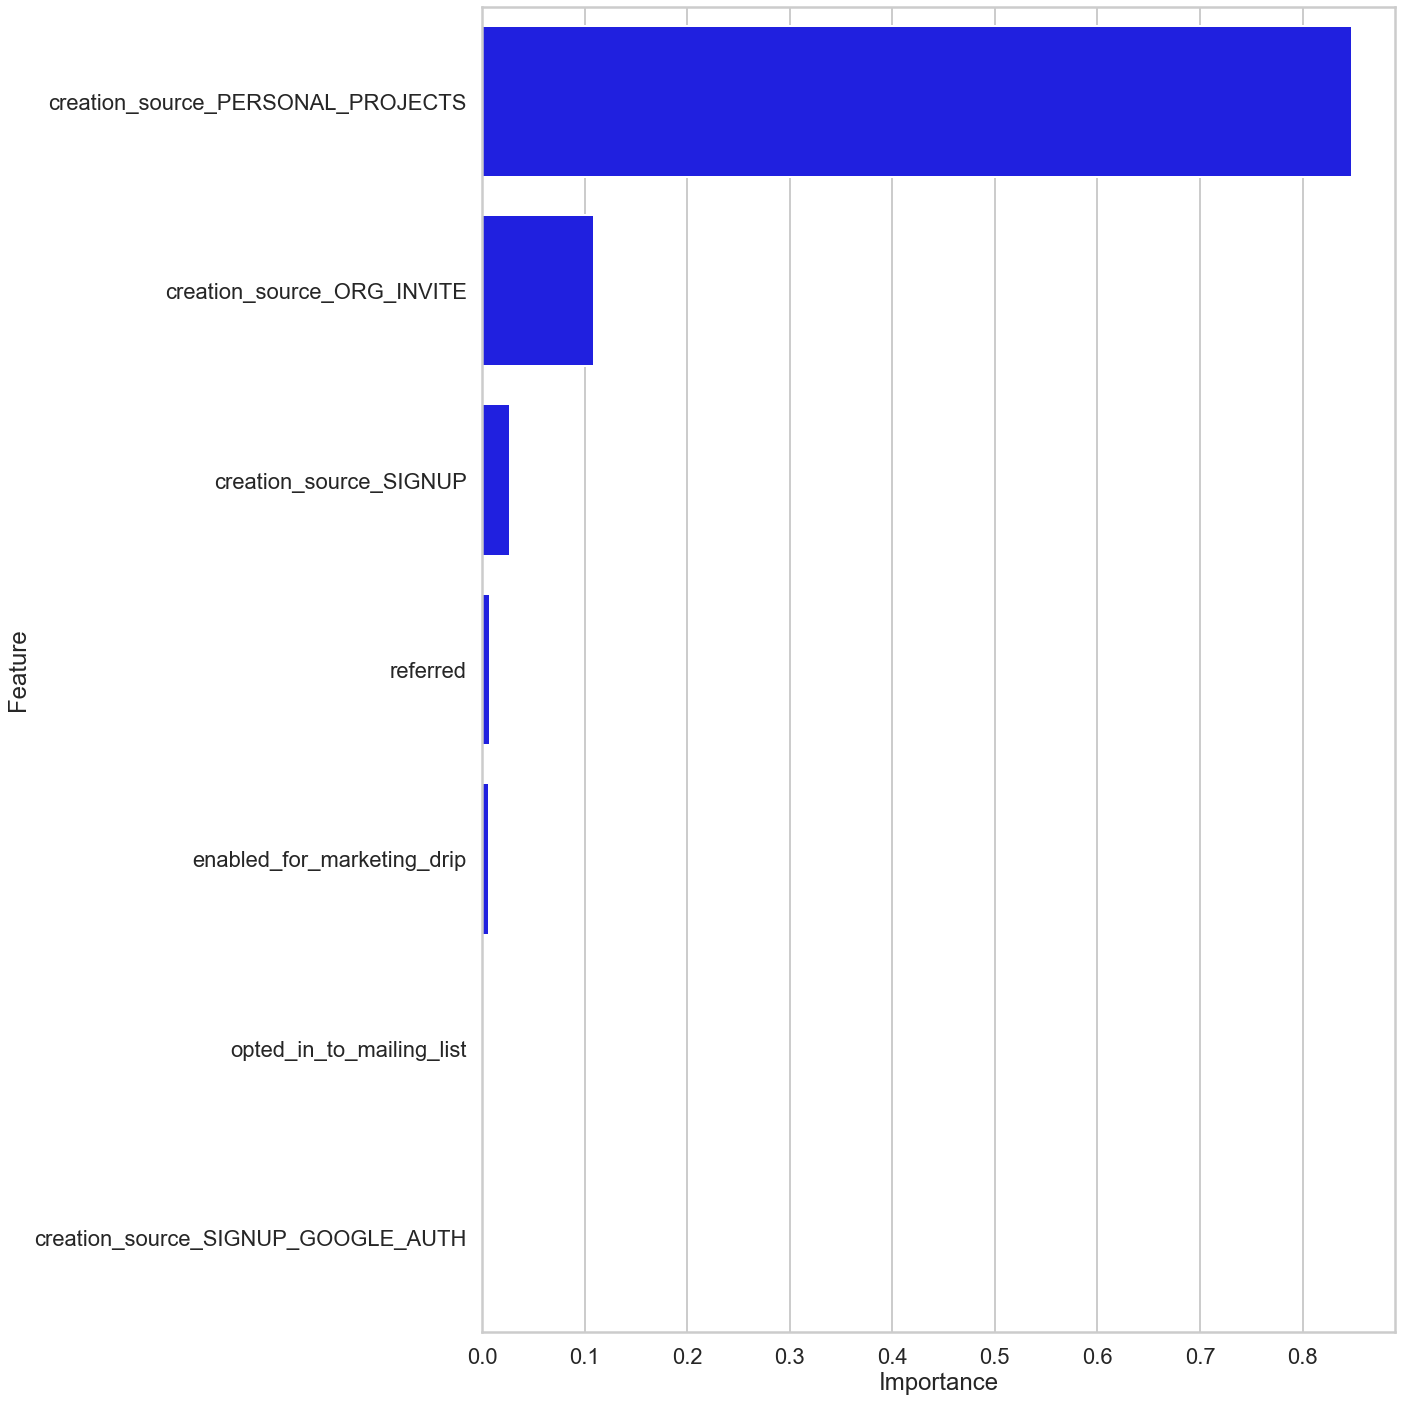

In [23]:
xgfeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xg.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = xgfeatureimportance, color = 'b')
plt.tight_layout()

# Model 2 - Random Forest

In [24]:
rf = RandomForestClassifier()
params = {'n_estimators': [100],
         'max_depth': randint(10, 50),
         'min_samples_split': randint(2,20),
         'min_samples_leaf': randint(1, 20),
         'n_jobs': [-1],
          'class_weight': ['balanced']
        }

cvrf = RandomizedSearchCV(rf, param_distributions = params, n_iter = 10, n_jobs = -1, scoring = 'f1', random_state = 123)
cvrf.fit(X_train, y_train)

pd.DataFrame(cvrf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.497669,0.061496,0.070212,0.014461,balanced,42,16,16,100,-1,"{'class_weight': 'balanced', 'max_depth': 42, ...",0.204167,0.224832,0.227236,0.225021,0.242424,0.224736,0.012185,1
8,0.470357,0.024946,0.044082,0.009300,balanced,30,16,18,100,-1,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.199350,0.224832,0.227236,0.225021,0.242424,0.223773,0.013849,2
9,0.388380,0.042588,0.031715,0.009343,balanced,17,10,5,100,-1,"{'class_weight': 'balanced', 'max_depth': 17, ...",0.199350,0.224039,0.227236,0.225021,0.242424,0.223614,0.013841,3
2,0.438428,0.064821,0.057447,0.012890,balanced,42,18,17,100,-1,"{'class_weight': 'balanced', 'max_depth': 42, ...",0.204167,0.224039,0.227236,0.219005,0.242424,0.223374,0.012380,4
0,0.314160,0.001668,0.057047,0.002476,balanced,12,3,8,100,-1,"{'class_weight': 'balanced', 'max_depth': 12, ...",0.199350,0.224039,0.227236,0.219005,0.242424,0.222411,0.013928,5
1,0.392551,0.092784,0.077792,0.029091,balanced,27,11,3,100,-1,"{'class_weight': 'balanced', 'max_depth': 27, ...",0.199350,0.218914,0.227236,0.219005,0.242424,0.221386,0.013959,6
6,0.466154,0.065373,0.059440,0.014517,balanced,14,18,5,100,-1,"{'class_weight': 'balanced', 'max_depth': 14, ...",0.199350,0.218914,0.227236,0.219005,0.242424,0.221386,0.013959,6
7,0.449797,0.041256,0.056648,0.005621,balanced,12,8,4,100,-1,"{'class_weight': 'balanced', 'max_depth': 12, ...",0.199350,0.219622,0.227236,0.216777,0.242424,0.221082,0.014045,8
3,0.425262,0.036348,0.053061,0.008640,balanced,19,1,16,100,-1,"{'class_weight': 'balanced', 'max_depth': 19, ...",0.199350,0.224832,0.227236,0.219005,0.230769,0.220238,0.011125,9
5,0.431250,0.041380,0.050262,0.005442,balanced,46,1,18,100,-1,"{'class_weight': 'balanced', 'max_depth': 46, ...",0.199350,0.218914,0.227236,0.219005,0.230769,0.219055,0.010885,10


In [25]:
rf = cvrf.best_estimator_
y_pred = rf.predict(X_test)
classification_report(y_test, y_pred, output_dict = True)['1']

{'precision': 0.14735099337748345,
 'recall': 0.5443425076452599,
 'f1-score': 0.2319218241042345,
 'support': 327}

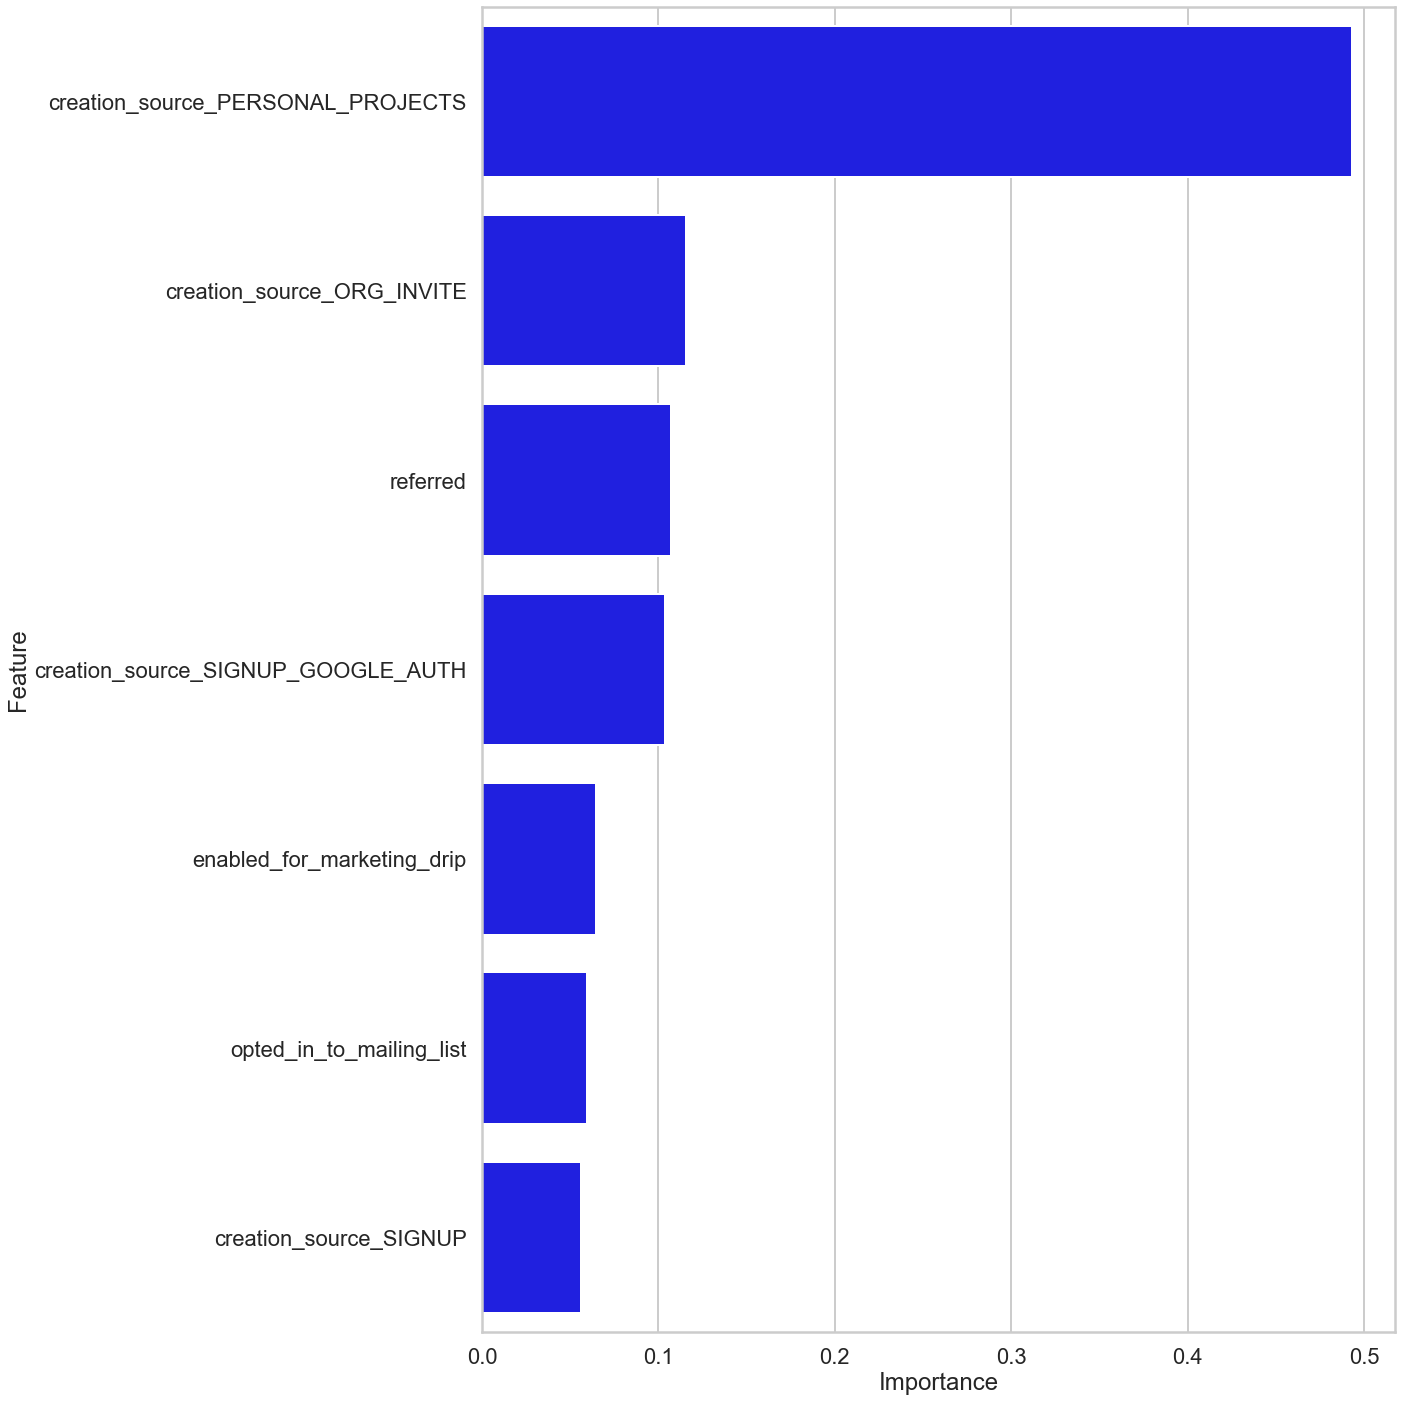

In [26]:
rffeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = rffeatureimportance, color = 'b')
plt.tight_layout()

In [43]:
pd.pivot_table(users, index = 'org_id', values = 'target', aggfunc = ['mean', 'count']).sort_values(('mean', 'target'), ascending = False)

,mean,count
,target,target
org_id,,
387,0.500000,12
235,0.461538,13
270,0.428571,14
399,0.384615,13
400,0.375000,8
...,...,...
349,0.000000,22
355,0.000000,9
